In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
import string
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import match

from famo.core import CORE

warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
def generate_dataset(n_samples, n_features, n_factors):
    z = np.random.randn(n_samples, n_factors)
    w = np.random.randn(n_factors, n_features)
    loc = 1 / (1 + np.exp(-(z @ w)))

    obs_total = np.random.poisson(100)
    obs_allelic = np.random.binomial(obs_total, loc)

    var_names = [
        "".join(random.choices(string.ascii_letters + string.digits, k=4))
        for _ in range(n_features)
    ]
    var_names_ref = [f"{name}_ref" for name in var_names]
    var_names_alt = [f"{name}_alt" for name in var_names]

    adata_ref = ad.AnnData(
        X=obs_allelic,
        var=pd.DataFrame(index=var_names_ref),
        obs=pd.DataFrame(index=[f"cell_{i}" for i in range(n_samples)]),
    )
    adata_alt = ad.AnnData(
        X=obs_total - obs_allelic,
        var=pd.DataFrame(index=var_names_alt),
        obs=pd.DataFrame(index=[f"cell_{i}" for i in range(n_samples)]),
    )
    adata = ad.concat([adata_ref, adata_alt], axis=1, merge="same")

    adata.obsm["z"] = z
    adata.uns["w"] = w
    adata.uns["genes"] = var_names

    return adata, z, w, var_names


adata, z_gt, w_gt, var_names = generate_dataset(500, 100, 3)

In [5]:
# Run model with MuData object
model = CORE(device="cuda")
model.fit(
    n_factors=3,
    data={"allelic": adata},
    likelihoods={"allelic": "BetaBinomial"},
    factor_prior="Normal",
    weight_prior="Normal",
    lr=0.005,
    early_stopper_patience=500,
    print_every=500,
    center_groups=True,
    scale_views=False,
    scale_groups=True,
    max_epochs=10000,
    save=True,
    save_path=None,
    init_factors="random",
    init_scale=0.1,
)

Setting up device...
- No device id given. Using default device: 0
- Running all computations on `cuda:0`
Fitting model...
- Checking compatibility of provided likelihoods with data.
  - allelic: BetaBinomial
Initializing factors using `random` method...
Epoch:       0 | Time:       1.03s | Loss:  244624.32
Epoch:     500 | Time:       5.04s | Loss:  179088.71
Epoch:    1000 | Time:       9.25s | Loss:  149884.23
Epoch:    1500 | Time:      13.03s | Loss:  147493.35
Training finished after 1945 steps.
Skipping view allelic for group group_1 as it does not have a Normal likelihood.
No R2 values found for group group_1. Skipping...
Sorting factors failed. Using default order.
Saving results...
- Model saved to model_20240616_133150/model.pkl
- Parameters saved to model_20240616_133150/params.save


In [7]:
w = model.get_weights()["allelic"].T
z = model.get_factors()["group_1"].T

w_gt = w_gt.T[np.argsort(np.array(var_names))]

inds = match(z_gt, z, dim=-1)
z = z[:, inds[0]] * inds[1]
w = w[:, inds[0]] * inds[1]

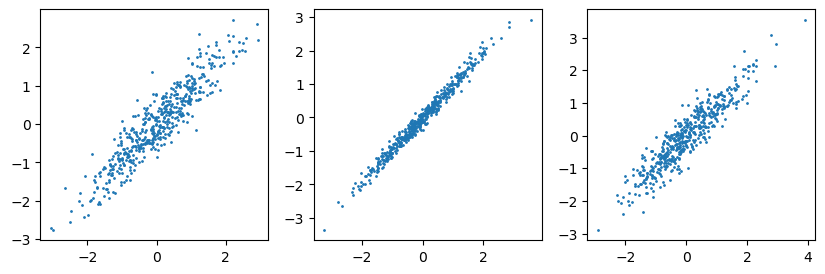

In [8]:
# correlation matrix of z and adata_allelic.obsm['z']
fig, axs = plt.subplots(1, z.shape[1], figsize=(10, 3))
for i in range(z.shape[1]):
    axs[i].scatter(z[:, i], z_gt[:, i], s=1)

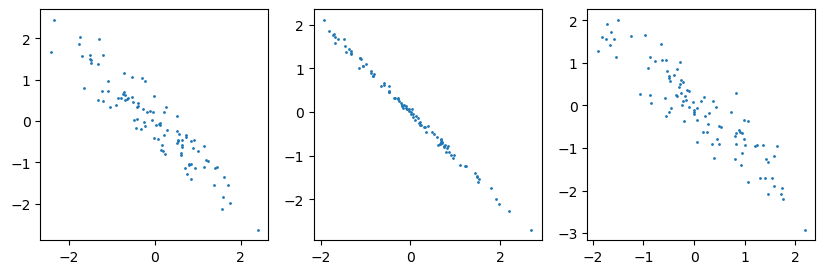

In [9]:
# correlation matrix of z and adata_allelic.obsm['z']
fig, axs = plt.subplots(1, z.shape[1], figsize=(10, 3))
for i in range(z.shape[1]):
    axs[i].scatter(w[:, i], w_gt[:, i], s=1)